<a href="https://colab.research.google.com/github/MouliChintakunta-AI/DLTutors/blob/main/GNN_with_different_activations_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import log_loss,accuracy_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelBinarizer
import matplotlib.colors
from sklearn.model_selection import train_test_split


In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",['red','blue','orange','green','purple'])

In [3]:
np.random.seed(0)

In [4]:
data,labels = make_blobs(n_features=2,n_samples=1000,centers=4,random_state=0)

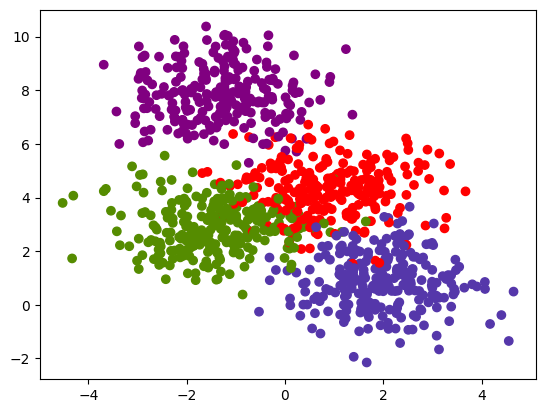

In [5]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,stratify = labels,test_size=.25,random_state=0)
print(X_train.shape)
print(Y_train.shape)

(750, 2)
(750,)


In [7]:
lb = LabelBinarizer()
Y_train_oh = lb.fit_transform(Y_train)
Y_train_oh.shape

(750, 4)

In [8]:
class GNN:

  def __init__(self,n_inputs=2,n_outputs=4,hidden=[2,4],activations = ["sigmoid","tanh"],leaky_slope=0.01):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden)
    self.sizes = [n_inputs] + hidden + [n_outputs] # [2 2 4 4]
    self.activations = activations
    self.final_activations = activations + ["softmax"]
    self.W = {}
    self.B = {}
    self.leaky_slope = leaky_slope
    for i in range(self.nh+1):
      if self.final_activations[i] in ('sigmoid','tanh','softmax'):
        self.W[i+1] = np.random.randn(self.sizes[i],self.sizes[i+1]) * np.sqrt(1 / self.sizes[i])
        self.B[i+1] = np.random.randn(1,self.sizes[i+1])
      elif self.final_activations[i] in ('relu','leaky_relu'):
        self.W[i+1] = np.random.randn(self.sizes[i],self.sizes[i+1]) * np.sqrt(2 / self.sizes[i])
        self.B[i+1] = np.random.randn(1,self.sizes[i+1])
      else:
        self.W[i+1] = np.random.randn(self.sizes[i],self.sizes[i+1])
        self.B[i+1] = np.random.randn(1,self.sizes[i+1])

  def sigmoid(self,X):
    return 1.0 / (1.0 + np.exp(-X))

  def tanh(self,X):
    return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

  def grad_tanh(self,X):
    return (1- np.power(X,2))

  def grad_sigmoid(self,X):
    return X * (1-X)

  def relu(self,X):
    return np.maximum(0,X)

  def leaky_relu(self,X):
    return np.maximum(self.leaky_slope *X , X)

  def grad_relu(self,X):
    return 1.0 * (X>0)

  def grad_leaky_relu(self,X):
    d = np.zeros_like(X)
    d[X<= 0] = self.leaky_slope
    d[X>0] = 1
    return d

  def softmax(self,X):
    exp = np.exp(X)
    return exp/np.sum(exp,1).reshape(-1,1)

  def forward_activation(self,layer):
    if self.activations[layer] == "sigmoid":
      self.H[layer+1] = self.sigmoid(self.A[layer+1])
    elif self.activations[layer] == 'tanh':
      self.H[layer+1] = self.tanh(self.A[layer+1])
    elif self.activations[layer] == 'relu':
      self.H[layer+1] = self.relu(self.A[layer+1])
    else:
      self.H[layer+1] = self.leaky_relu(self.A[layer+1])

  def grad_activation(self,k):
    if self.activations[k-2] == "sigmoid":
      self.dA[k-1] = np.multiply(self.dH[k-1],self.grad_sigmoid(self.H[k-1]))
    elif self.activations[k-2] == "relu":
      self.dA[k-1] = np.multiply(self.dH[k-1],self.grad_relu(self.H[k-1]))
    elif self.activations[k-2] == "leaky_relu":
      self.dA[k-1] = np.multiply(self.dH[k-1],self.grad_leaky_relu(self.H[k-1]))
    else:
      self.dA[k-1] = np.multiply(self.dH[k-1],self.grad_tanh(self.H[k-1]))

  def forward_pass(self,X):
    self.H = {}
    self.A = {}
    self.H[0] = X
    for i in range(self.nh+1): # 3
      self.A[i+1] = np.matmul(self.H[i],self.W[i+1]) + self.B[i+1]
      if self.ny == 1 or i < self.nh:
        self.forward_activation(i)
      else:
        self.H[i+1] = self.softmax(self.A[i+1])
    return self.H[self.nh+1]

  def grad(self,X,Y):
    self.forward_pass(X)
    L = self.nh+1
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    self.dA[L] = self.H[L] - Y
    for k in range(L,0,-1):
      self.dW[k] = np.matmul(self.H[k-1].T,self.dA[k])
      self.dB[k] = np.sum(self.dA[k],0).reshape(1,-1)
      self.dH[k-1] = np.matmul(self.dA[k],self.W[k].T)
      self.grad_activation(k)

  def fit(self,X,Y,epochs= 2000,learning_rate= .2,display_loss = True):
    if display_loss:
      loss ={}
    m = X.shape[0]
    for epoch in tqdm(range(epochs),desc="Training GNN",unit='epoch'):
      self.grad(X,Y)
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (self.dW[i+1] / m)
        self.B[i+1] -= learning_rate * (self.dB[i+1] / m)
      if display_loss:
        y_pred = self.predict(X)
        error = log_loss(Y,y_pred)
        loss[epoch] = error
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel("Epochs")
      plt.ylabel("Log_loss")
      plt.show()

  def predict(self,X):
    y_pred = self.forward_pass(X)
    return y_pred.squeeze()

In [9]:
# a = np.array([[1,2,3,4],[2,5,6,7]])
# exp_a = np.exp(a)
# exp_a/np.sum(exp_a,1).reshape(-1,1)

Training GNN: 100%|██████████| 3000/3000 [00:11<00:00, 255.40epoch/s]


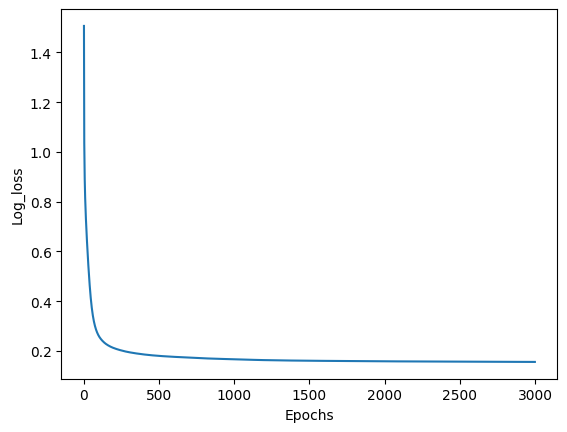

In [17]:
model = GNN(X_train.shape[1],Y_train_oh.shape[1],hidden=[16,16],activations=['leaky_relu','leaky_relu'])
model.fit(X_train,Y_train_oh,learning_rate = .05,epochs=3000)

In [18]:
train_loss = model.predict(X_train)
train_accuracy = accuracy_score(Y_train,np.argmax(train_loss,1))
print("Training Accuracy:",train_accuracy)
test_loss = model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(test_loss,1),Y_test)
print("Test Accuracy:",test_accuracy)

Training Accuracy: 0.932
Test Accuracy: 0.948


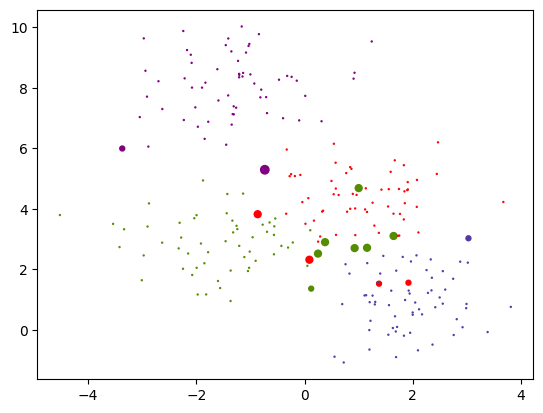

In [12]:
plt.scatter(X_test[:,0],X_test[:,1],c= Y_test,cmap=my_cmap,s= 12 * np.abs(np.argmax(test_loss,1) - Y_test) +.5)

In [13]:
train_loss = model.predict(X_train)
train_accuracy = accuracy_score(Y_train,np.argmax(train_loss,1))
print("Training Accuracy:",train_accuracy)
test_loss = model.predict(X_test)
test_accuracy = accuracy_score(np.argmax(test_loss,1),Y_test)
print("Test Accuracy:",test_accuracy)

Training Accuracy: 0.9306666666666666
Test Accuracy: 0.944


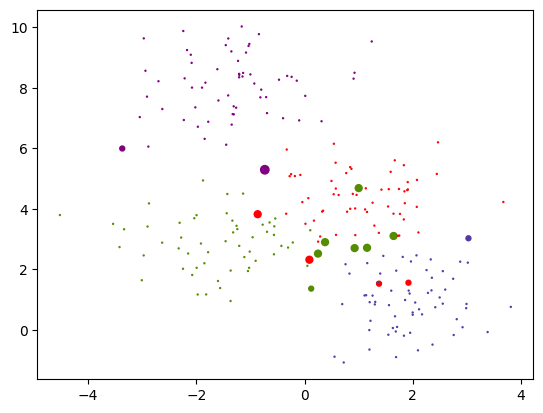

In [14]:
plt.scatter(X_test[:,0],X_test[:,1],c= Y_test,cmap=my_cmap,s= 12 * np.abs(np.argmax(test_loss,1) - Y_test) +.5)